In [7]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import pdist, squareform
import numpy as np
from sklearn.cluster import KMeans

In [3]:
def generate_population(N_pop, N_cen=5):
    n = N_pop // N_cen
    cen = np.random.random((N_cen, 2))
    sigma = 0.1
    for i in range(N_cen):
        if i == N_cen-1:
            n = N_pop - n*i
        pop_i = cen[i, :] + sigma*np.random.randn(n, 2)
        if i == 0:
            pop = pop_i
        else:
            pop = np.append(pop, pop_i, axis=0)
    return pop

def generate_population_2(N_pop):
    return np.random.randn(N_pop, 2)

def generate_locations(N_loc, pop):
    min = pop.min(axis=0)
    max = pop.max(axis=0)
    d = max - min
    loc = np.random.random((N_loc, 2))
    loc = min + d * loc
    cost = 100 + np.random.random(N_loc) * 100
    return loc, cost

In [4]:
def plot_result(popi=None, popg=None, loc=None, x=None):
    plt.figure(figsize=(8,8), dpi=80)
    if popi is not None:
        plt.scatter(*zip(*popi), c='Pink', s=0.5)
    if popg is not None:
        plt.scatter(*zip(*popg), c='Red', s=10)
    if loc is not None:
        plt.scatter(*zip(*loc), c='Green', s=10)
    if x is not None:
        for p in range(popg.shape[0]):
            for h in range(loc.shape[0]):
                if x[h,p].x > 0.5:
                    pts = [loc[h], popg[p]]
                    plt.plot(*zip(*pts), c='Black', linewidth=0.1)

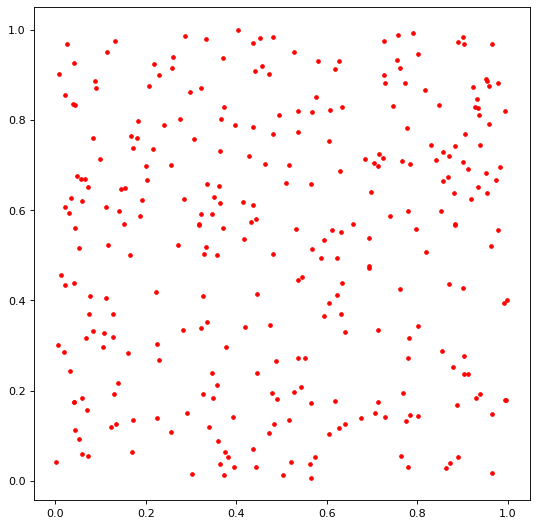

In [15]:

np.random.seed(1234)
pop_size=300
pop = np.random.uniform(size=(pop_size, 2))
pop_dist = [1975132/4827184,2361745/4827184, 448404/4827184, 36683/4827184, 5220/4827184]    
pop_demand = np.random.choice([1,2,3,4,5],size=pop_size, replace=True, p=pop_dist) 
plot_result(popg=pop)

517


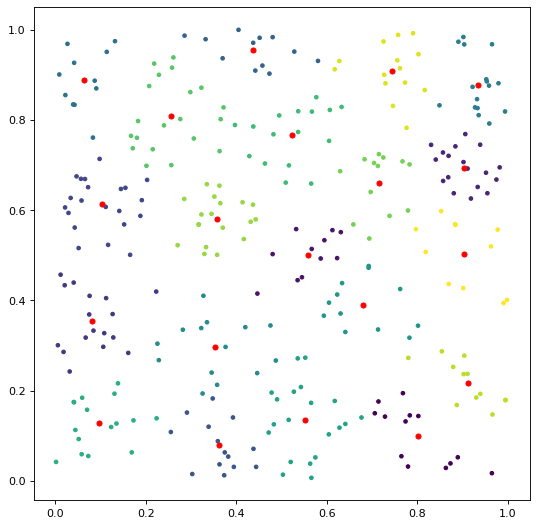

In [16]:
def cluster_pop(pop, N, pop_demand):
    kmeans = KMeans(n_clusters=N, algorithm="full", init='k-means++').fit(pop)
    cen = kmeans.cluster_centers_
    w = np.zeros(N, dtype=np.int64)
    for i in range(N):
        w[i] = np.sum(pop_demand[kmeans.labels_ == i])
    labels = kmeans.predict(pop)
    
    return cen, labels, w

cen, labels, w = cluster_pop(pop, 20,pop_demand)

print(w.sum())

plt.figure(figsize=(8,8), dpi=80)
plt.scatter(*zip(*pop), c=labels, s=10)
plt.scatter(*zip(*cen), c='Red', s=20)
plt.show()

In [17]:
def dist(loc1, loc2):
    return np.linalg.norm(loc1-loc2, ord=2) # Euclidean distance

def compute_distance(pop, center=[0,0]):
    N = pop.shape[0] + 1
    D = np.zeros((N, N))
    _pop = pop[:]
    _pop = np.append([center], _pop, axis=0)
    for i in range(N):
        for j in range(N):
            D[i, j] = dist(_pop[i], _pop[j])
    return D

In [12]:
from gurobipy import *

def VRP_GUROBI (pop, cap, demand):
    m = Model("VRP")

    N = pop.shape[0] + 1
    D = compute_distance(pop)

    x, y = {}, {}
    for i in range(N):
        for j in range(N):
            x[i, j] = m.addVar(vtype=GRB.BINARY, name="x%d,%d" % (i, j))
        y[i] = m.addVar(vtype=GRB.INTEGER, name="y%d" % (i))
    nov = m.addVar(vtype=GRB.INTEGER, name="nov")
    
    for i in range(N):
        m.addConstr(x[i, i] == 0)

    for i in range(N - 1):
        m.addConstr(quicksum(x[(i + 1, j)] for j in range(N)) == 1)
    m.update()

    # vehicles arriving to each customer node
    for j in range(N - 1):
        m.addConstr(quicksum(x[(i, j + 1)] for i in range(N)) == 1)
    m.update()

    # vehicles leaving depot
    m.addConstr(quicksum(x[(0, j)] for j in range(N)) == nov)
    m.update()

    # vehicles arriving to depot
    m.addConstr(quicksum(x[(i, 0)] for i in range(N)) == nov)
    m.update()
    
    for j in range(N - 1):
        m.addConstr(y[j + 1] <= cap)
        m.addConstr(y[j + 1] >= demand[j])
        for i in range(N - 1):
            m.addConstr(y[j + 1] >= y[i + 1] + 1 * demand[j] * (x[i + 1, j + 1]) - cap * (1 - (x[i + 1, j + 1])))
    m.update()
    
    m.setObjective(quicksum(quicksum(x[(i, j)]*D[(i, j)] for j in range(N)) for i in range(N)), GRB.MINIMIZE)
    m.update()
    
    m.optimize()
    
    return m, x, y, nov

In [13]:
#demand = [1 for i in range(cen.shape[0])]
m, x, y, nov = VRP_GUROBI (cen, 100, w)
n = cen.shape[0] + 1
sol_y, sol_x = m.getAttr('x', y), m.getAttr('x', x)
X, Y = np.empty([n, n]), np.empty([n])
for i in range(n):
    Y[i] = sol_y[i]
    for j in range(n):
        X[i, j] = int(sol_x[i, j])
print('\nObjective is:', m.objVal)
print('\nDecision variable X (binary decision of travelling from one node to another):\n', X.astype('int32'))
print('\nDecision variable Y: ', Y.astype('int32'))
print('Number of Vehicles: ', nov.x)

print([[i, j] for i in range(X.shape[0]) for j in range(X.shape[1]) if X[i, j] ==1])

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 40 physical cores, 40 logical processors, using up to 32 threads

Optimize a model with 503 rows, 463 columns and 2105 nonzeros
Model fingerprint: 0x4687a6d9
Variable types: 0 continuous, 463 integer (441 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [3e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 82 rows and 23 columns
Presolve time: 0.01s
Presolved: 421 rows, 440 columns, 1980 nonzeros
Variable types: 0 continuous, 440 integer (420 binary)
Found heuristic solution: objective 66.0258290

Root relaxation: objective 2.313580e+01, 102 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

In [ ]:
_cen = np.append([[0, 0]], cen, axis=0)
def plot_tours(solution_x):
    tours = [[i, j] for i in range(solution_x.shape[0]) for j in range(solution_x.shape[1]) if solution_x[i, j] ==1]
    plt.figure(figsize=(8,8), dpi=80)
    for t, tour in enumerate(tours):
        plt.plot(_cen[:,0][tour], _cen[:,1][tour], color = "black", linewidth=0.5)
        
    plt.scatter(_cen[:,0][1:], _cen[:,1][1:], color = 'g')
    plt.scatter(_cen[:,0][0], _cen[:,1][0], color = 'b',s=20)
    plt.xlabel("X"), plt.ylabel("Y"), plt.title("Tours")
    plt.show()
plot_tours(X)

In [27]:
print(demand)
print(w)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[38 48 38 11 18 48 21 12 24 27 39  7 31  7 43 15 26  6 25 16]


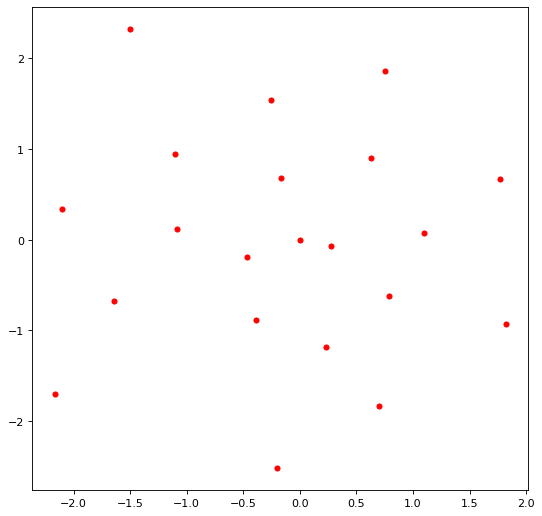

In [28]:
plt.figure(figsize=(8,8), dpi=80)
plt.scatter(*zip(*_cen), c='Red', s=20)
plt.show()